In [13]:
# # 06_metrics_cleaned.ipynb

# %%
# Imports & basic setup
import os
import sys
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# --- Path Setup ---
PROJECT_ROOT = os.path.abspath("..")
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

from modules.plot_utils import _save_and_show_plot
# plotting style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

# ensure project root 
PROJECT_ROOT = os.path.abspath("..")
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)


In [14]:
# %%
# Configuration
ASSETS = ["FX_USDINR", "BOND_BNDX", "COM_CRUDE"] 
TRAIN_END = pd.to_datetime("2019-12-31")
SHOCK_PERIODS = {
    "covid_shock": ("2020-02-15", "2020-06-30"),
    "inflation_energy_shock": ("2022-02-01", "2022-12-31"),
    "oil_spike_shock": ("2024-07-01", "2025-03-31"),
}
# CSV files residual vol uses percentage so we SCALE to 100 

PRED_SCALE = 100.0

# Create merged file merging garch and sv test data
GARCH_PATH = "results/garch"
SV_PATH = "results/sv"
RESULTS_PATH = "results/merged_test"
os.makedirs(RESULTS_PATH, exist_ok=True)

# --------------------------------------------
# Merge per-asset GARCH & SV test files and compute realized_vol
# --------------------------------------------
for asset in ASSETS:
    garch_path = f"{GARCH_PATH}/{asset}_garch_test.csv"
    sv_path = f"{SV_PATH}/{asset}_sv_test.csv"
    if not (os.path.exists(garch_path) and os.path.exists(sv_path)):
        print(f"Missing test files for {asset}")
        continue

    garch_df = pd.read_csv(garch_path, parse_dates=["date"])
    sv_df = pd.read_csv(sv_path, parse_dates=["date"])

     # Merge on date — both contain return, log_return, etc.
    merged = (
        garch_df[["date", "return", "log_return", "garch_vol"]]
        .merge(
            sv_df[["date", "sv_vol"]],
            on="date",
            how="inner"
        )
    )
    # Compute realized volatility: 5-day rolling std of log returns 
    # (annualized, %)
    merged["realized_vol"] = (
        merged["log_return"].rolling(window=5).std() * np.sqrt(252) * 100
    )

    merged.to_csv(f"{RESULTS_PATH}/{asset}_merged_test.csv", index=False)
    print(f" Saved merged test file for {asset} with realized_vol.")
    merged.to_csv(f"{RESULTS_PATH}/{asset}_merged_test.csv", index=False)
    print(f" Merged {asset} test file saved.")

print("\nAll merged test files created successfully.")



 Saved merged test file for FX_USDINR with realized_vol.
 Merged FX_USDINR test file saved.
 Saved merged test file for BOND_BNDX with realized_vol.
 Merged BOND_BNDX test file saved.
 Saved merged test file for COM_CRUDE with realized_vol.
 Merged COM_CRUDE test file saved.

All merged test files created successfully.


In [15]:
# %%
# --------------------------------------------
# Metric functions
# --------------------------------------------
def qlike(y_true, y_pred):
    # Quasi-likelihood loss used in volatility forecasting (lower = better).
    # y_pred and y_true should be on same scale.
    eps = 1e-8
    return np.mean(np.log(y_pred**2 + eps) + (y_true**2) / (y_pred**2 + eps))

def directional_accuracy(y_true, y_pred):
    # Proportion of times the model direction (up/down) matches realized direction.
    if len(y_true) < 2 or len(y_pred) < 2:
        return np.nan
    real_diff = np.sign(np.diff(y_true))
    model_diff = np.sign(np.diff(y_pred))
    # If lengths differ after mask, compare minimum length
    L = min(len(real_diff), len(model_diff))
    return np.mean(real_diff[:L] == model_diff[:L])

def safe_corr(x, y):
    # Return Pearson correlation if possible, else NaN.
    if len(x) < 2 or len(y) < 2:
        return np.nan
    if np.all(np.isclose(x, x[0])) or np.all(np.isclose(y, y[0])):
        return np.nan
    return np.corrcoef(x, y)[0, 1]

def compute_metrics(y_true, y_pred):
    # Compute full set of metrics given arrays (same scale).
    mask = (~np.isnan(y_true)) & (~np.isnan(y_pred))
    y_true, y_pred = np.asarray(y_true)[mask], np.asarray(y_pred)[mask]
    if len(y_true) == 0:
        return {
            "RMSE": np.nan, "MAE": np.nan, "Correlation": np.nan,
            "Directional_Accuracy": np.nan, "QLIKE": np.nan
        }
    return {
        "RMSE": np.sqrt(np.mean((y_true - y_pred) ** 2)),
        "MAE": np.mean(np.abs(y_true - y_pred)),
        "Correlation": safe_corr(y_true, y_pred),
        "Directional_Accuracy": directional_accuracy(y_true, y_pred),
        "QLIKE": qlike(y_true, y_pred),
    }


In [16]:

# -------------------------
# Compare pre- vs post-recalibration
# -------------------------

def compare_recalibration(asset, merged_csv, shock_start, shock_end, recalib_date):
    df = pd.read_csv(merged_csv, parse_dates=["date"])
    if "realized_vol" not in df.columns:
        df["realized_vol"] = df["log_return"].rolling(5).std() * np.sqrt(252) * 100

    # Scale predictions
    df["garch_vol"] *= PRED_SCALE
    df["sv_vol"] *= PRED_SCALE

    # Split pre- and post-recalibration
    pre = df[(df["date"] >= shock_start) & (df["date"] < recalib_date)]
    post = df[(df["date"] >= recalib_date) & (df["date"] <= shock_end)]

    table_rows = []
    for model_col, model_name in [("garch_vol", "GARCH"), ("sv_vol", "SV")]:
        pre_metrics = compute_metrics(pre["realized_vol"], pre[model_col])
        post_metrics = compute_metrics(post["realized_vol"], post[model_col])
        
        row = {"Asset": asset, "Model": model_name}
        for metric in pre_metrics:
            diff = post_metrics[metric] - pre_metrics[metric]
            if metric in ["RMSE", "MAE", "QLIKE"]:
                status = "Improved" if diff < 0 else "Worsened"
            else:  # Correlation, Directional_Accuracy
                status = "Improved" if diff > 0 else "Worsened"
            row[metric] = status
        table_rows.append(row)

    return table_rows


# Collect results for all assets
all_results = []
for asset in ASSETS:
    all_results.extend(
        compare_recalibration(
            asset=asset,
            merged_csv=f"{RESULTS_PATH}/{asset}_merged_test.csv",
            shock_start="2020-02-15",
            shock_end="2020-06-30",
            recalib_date="2020-04-15"
        )
    )

# Convert to DataFrame and display nicely
table_df = pd.DataFrame(all_results)
print(table_df.to_string(index=False))


    Asset Model     RMSE      MAE Correlation Directional_Accuracy    QLIKE
FX_USDINR GARCH Worsened Worsened    Worsened             Worsened Improved
FX_USDINR    SV Worsened Worsened    Worsened             Worsened Improved
BOND_BNDX GARCH Worsened Worsened    Worsened             Improved Improved
BOND_BNDX    SV Worsened Worsened    Improved             Improved Worsened
COM_CRUDE GARCH Worsened Worsened    Improved             Improved Improved
COM_CRUDE    SV Worsened Worsened    Improved             Improved Worsened


In [28]:

# -------------------------
# Compare pre- vs during vs post-shock
# -------------------------

def compare_shock(asset, merged_csv, shock_start, shock_end, window_length = 30):
    df = pd.read_csv(merged_csv, parse_dates=["date"])
    if "realized_vol" not in df.columns:
        df["realized_vol"] = df["log_return"].rolling(5).std() * np.sqrt(252) * 100

    # Scale predictions
    df["garch_vol"] *= PRED_SCALE
    df["sv_vol"] *= PRED_SCALE


    # Convert dates
    shock_start_dt = pd.to_datetime(shock_start)
    shock_end_dt = pd.to_datetime(shock_end)
   

    # Split pre- during - and- post-mid point of shock 
    pre_window = df[df["date"] < shock_start_dt].tail(window_length)
    during_window = df[(df["date"] >= shock_start_dt) &  (df["date"] <= shock_end_dt)].tail(window_length)
    post_window = df[df["date"] >= shock_end_dt].head(window_length)

    table_rows = []
    for model_col, model_name in [("garch_vol", "GARCH"), ("sv_vol", "SV")]:
        pre_metrics = compute_metrics(pre_window["realized_vol"], pre_window[model_col])
        during_metrics = compute_metrics(during_window["realized_vol"], during_window[model_col])
        post_metrics = compute_metrics(post_window["realized_vol"], post_window[model_col])
        
        row = {"Asset": asset, "Model": model_name, "Shock": shock_name}
        for metric in pre_metrics:
            diff1 = during_metrics[metric]-pre_metrics[metric]
            if metric in ["RMSE", "MAE", "QLIKE"]:
                status1 = "Improved pre to during" if diff1 < 0 else "Worsened pre to during"
            else:  # Correlation, Directional_Accuracy
                status1 = "Improved pre to during" if diff1 > 0 else "Worsened pre to during"
            row[f"{metric} pre to during"] = status1
            diff2 = post_metrics[metric] - during_metrics[metric]
            if metric in ["RMSE", "MAE", "QLIKE"]:
                status2 = "Improved during to after" if diff2 < 0 else "Worsened during to after"
            else:  # Correlation, Directional_Accuracy
                status2 = "Improved  during to after" if diff2 > 0 else "Worsened  during to after"
            row[f"{metric} during to post"] = status2
        table_rows.append(row)

    return table_rows


# Collect results for all assets
all_results = []
for asset in ASSETS:
    for shock_name, (shock_start,shock_end) in SHOCK_PERIODS.items():
        all_results.extend(
            compare_shock(
                asset=asset,
                merged_csv=f"{RESULTS_PATH}/{asset}_merged_test.csv",
                shock_start=shock_start,
                shock_end=shock_end
        )
    )

# Convert to DataFrame and display nicely
table_df = pd.DataFrame(all_results)
print(table_df.to_string(index=False))


    Asset Model                  Shock     RMSE pre to during      RMSE during to post      MAE pre to during       MAE during to post Correlation pre to during Correlation during to post Directional_Accuracy pre to during Directional_Accuracy during to post    QLIKE pre to during     QLIKE during to post
FX_USDINR GARCH            covid_shock Improved pre to during Worsened during to after Improved pre to during Worsened during to after    Worsened pre to during  Improved  during to after             Worsened pre to during           Worsened  during to after Improved pre to during Improved during to after
FX_USDINR    SV            covid_shock Worsened pre to during Improved during to after Worsened pre to during Improved during to after    Improved pre to during  Worsened  during to after             Worsened pre to during           Improved  during to after Worsened pre to during Improved during to after
FX_USDINR GARCH inflation_energy_shock Improved pre to during Improved during t

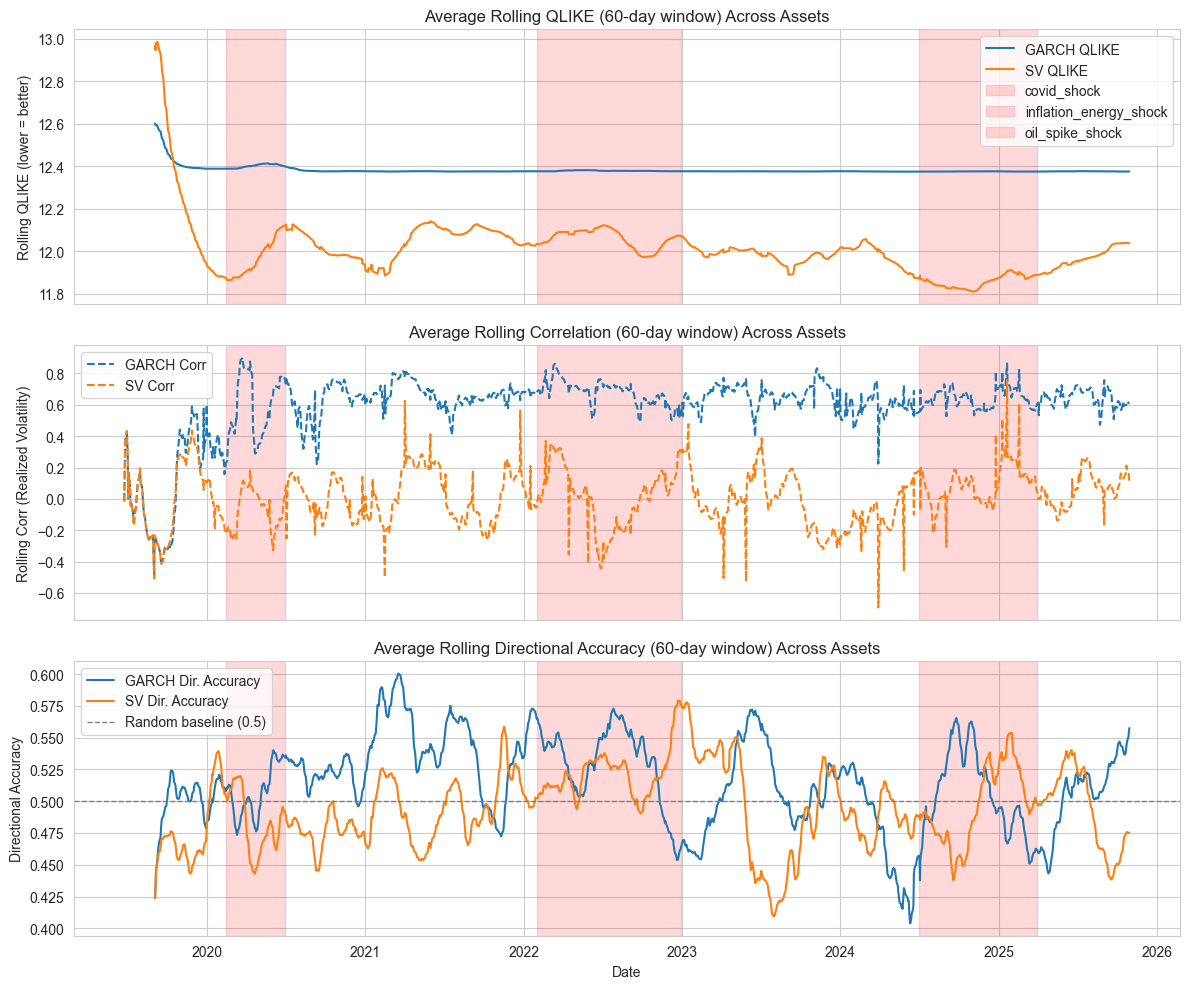

In [18]:

# --------------------------------------------
# Rolling QLIKE, Correlation & Directional Accuracy Visualizations
# --------------------------------------------
ROLL_WINDOW = 60  # 3-month window on daily data
SMOOTH_WINDOW = 10  # for smoothing noisy metrics
agg_frames = []

def rolling_qlike(y_true, y_pred, window):
    out = []
    for i in range(len(y_true)):
        start = max(0, i - window)
        yt, yp = y_true[start:i], y_pred[start:i]
        if len(yt) < 10 or np.any(np.isnan(yt)) or np.any(np.isnan(yp)):
            out.append(np.nan)
        else:
            out.append(qlike(yt, yp))
    return pd.Series(out, index=y_true.index)


def rolling_directional_accuracy(y_true, y_pred, window):
    out = []
    for i in range(len(y_true)):
        start = max(0, i - window)
        yt, yp = y_true[start:i], y_pred[start:i]
        if len(yt) < 10 or np.any(np.isnan(yt)) or np.any(np.isnan(yp)):
            out.append(np.nan)
        else:
            out.append(directional_accuracy(yt, yp))
    return pd.Series(out, index=y_true.index)


for asset in ASSETS:
    path = f"{RESULTS_PATH}/{asset}_merged_test.csv"
    if not os.path.exists(path):
        continue

    df = pd.read_csv(path, parse_dates=["date"])
    if "realized_vol" not in df.columns:
        continue

    realized = df["realized_vol"]
    garch_pred = df["garch_vol"] * PRED_SCALE
    sv_pred = df["sv_vol"] * PRED_SCALE

    # Compute rolling metrics
    df["QLIKE_GARCH"] = rolling_qlike(realized, garch_pred, ROLL_WINDOW)
    df["QLIKE_SV"] = rolling_qlike(realized, sv_pred, ROLL_WINDOW)
    df["Corr_GARCH"] = realized.rolling(ROLL_WINDOW, min_periods=10).corr(garch_pred)
    df["Corr_SV"] = realized.rolling(ROLL_WINDOW, min_periods=10).corr(sv_pred)
    df["DA_GARCH"] = rolling_directional_accuracy(realized, garch_pred, ROLL_WINDOW)
    df["DA_SV"] = rolling_directional_accuracy(realized, sv_pred, ROLL_WINDOW)

    df["Asset"] = asset
    agg_frames.append(df[["date", "Asset", "QLIKE_GARCH", "QLIKE_SV",
                          "Corr_GARCH", "Corr_SV", "DA_GARCH", "DA_SV"]])

agg_df = pd.concat(agg_frames, ignore_index=True)
mean_df = (
    agg_df.groupby("date")[["QLIKE_GARCH", "QLIKE_SV",
                            "Corr_GARCH", "Corr_SV",
                            "DA_GARCH", "DA_SV"]]
    .mean()
    .reset_index()
)

# Smooth all metrics a bit for readability
mean_df["QLIKE_SV_smooth"] = mean_df["QLIKE_SV"].rolling(SMOOTH_WINDOW, min_periods=1).mean()
mean_df["QLIKE_GARCH_smooth"] = mean_df["QLIKE_GARCH"].rolling(SMOOTH_WINDOW, min_periods=1).mean()
mean_df["DA_SV_smooth"] = mean_df["DA_SV"].rolling(SMOOTH_WINDOW, min_periods=1).mean()
mean_df["DA_GARCH_smooth"] = mean_df["DA_GARCH"].rolling(SMOOTH_WINDOW, min_periods=1).mean()

# --------------------------------------------
# Plot all three panels
# --------------------------------------------
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# ---- Rolling QLIKE ----
axes[0].plot(mean_df["date"], mean_df["QLIKE_GARCH_smooth"], label="GARCH QLIKE", color="tab:blue")
axes[0].plot(mean_df["date"], mean_df["QLIKE_SV_smooth"], label="SV QLIKE", color="tab:orange")
axes[0].set_ylabel("Rolling QLIKE (lower = better)")
axes[0].legend()
axes[0].set_title("Average Rolling QLIKE (60-day window) Across Assets")

# ---- Rolling Correlation ----
axes[1].plot(mean_df["date"], mean_df["Corr_GARCH"], label="GARCH Corr", linestyle="--", color="tab:blue")
axes[1].plot(mean_df["date"], mean_df["Corr_SV"], label="SV Corr", linestyle="--", color="tab:orange")
axes[1].set_ylabel("Rolling Corr (Realized Volatility)")
axes[1].legend()
axes[1].set_title("Average Rolling Correlation (60-day window) Across Assets")

# ---- Rolling Directional Accuracy ----
axes[2].plot(mean_df["date"], mean_df["DA_GARCH_smooth"], label="GARCH Dir. Accuracy", color="tab:blue")
axes[2].plot(mean_df["date"], mean_df["DA_SV_smooth"], label="SV Dir. Accuracy", color="tab:orange")
axes[2].axhline(0.5, color="gray", linestyle="--", linewidth=1, label="Random baseline (0.5)")
axes[2].set_ylabel("Directional Accuracy")
axes[2].legend()
axes[2].set_title("Average Rolling Directional Accuracy (60-day window) Across Assets")

# ---- Highlight Shock Periods ----
for ax in axes:
    for shock_name, (start, end) in SHOCK_PERIODS.items():
        ax.axvspan(pd.to_datetime(start), pd.to_datetime(end),
                   color="red", alpha=0.15, label=shock_name if ax is axes[0] else None)

axes[-1].set_xlabel("Date")
axes[0].legend()
plt.tight_layout()
plt.show()



In [19]:
# %%
# --------------------------------------------
# Load per-asset overall metrics (entire sample or out-of-sample)
# --------------------------------------------
records = []

for asset in ASSETS:
    path = f"{RESULTS_PATH}/{asset}_merged_test.csv"
    if not os.path.exists(path):
        print(f" Missing file: {path}")
        continue

    df = pd.read_csv(path, parse_dates=["date"])
    if "realized_vol" not in df.columns:
        print(f" No realized_vol in {asset}")
        continue

    # use predictions scaled to same units as realized_vol
    for col, model in [("garch_vol", "GARCH"), ("sv_vol", "SV")]:
        if col not in df.columns:
            continue
        # scale model predictions to same units as realized_vol ( *100)
        preds = df[col].values * PRED_SCALE
        m = compute_metrics(df["realized_vol"].values, preds)
        m.update({"Asset": asset, "Model": model})
        records.append(m)

metrics_df = pd.DataFrame(records)
print("Per-asset metrics (entire sample):")
display(metrics_df)


Per-asset metrics (entire sample):


,RMSE,MAE,Correlation,Directional_Accuracy,QLIKE,Asset,Model
0,484.720160,484.391203,0.047827,0.542720,12.383939,FX_USDINR,GARCH
1,410.959230,401.666679,0.059790,0.491576,11.986311,FX_USDINR,SV
2,485.446662,485.101008,-0.081639,0.498442,12.384144,BOND_BNDX,GARCH
3,420.113032,409.428745,-0.064886,0.495327,12.020599,BOND_BNDX,SV
4,457.215398,456.243043,0.069758,0.503109,12.394112,COM_CRUDE,GARCH
5,407.295266,395.214864,0.122982,0.495025,12.099364,COM_CRUDE,SV


=== Average Performance Across Assets (raw) ===


,RMSE,MAE,Correlation,Directional_Accuracy,QLIKE
Model,,,,,
GARCH,475.794073,475.245085,0.011982,0.514757,12.387398
SV,412.789176,402.103430,0.039295,0.493976,12.035424


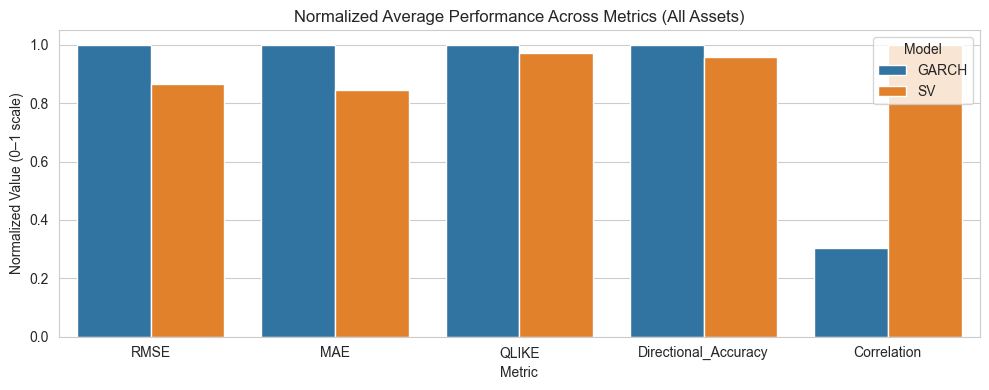

In [20]:
# %%
# --------------------------------------------
# Aggregate: Average performance across assets (raw numbers)
# --------------------------------------------

avg_metrics = metrics_df.groupby("Model").mean(numeric_only=True)
print("=== Average Performance Across Assets (raw) ===")
display(avg_metrics)

# --------------------------------------------
# Normalize metrics for visualization
# --------------------------------------------
normed = avg_metrics.copy()
normed = normed / normed.max()  # scale each metric 0–1 for comparison

# Melt for seaborn
melted = normed.reset_index().melt(
    id_vars="Model",
    value_vars=["RMSE", "MAE", "QLIKE", "Directional_Accuracy", "Correlation"],
    var_name="Metric",
    value_name="Normalized_Value"
)

# --------------------------------------------
# Plot normalized averages
# --------------------------------------------
fig = plt.figure(figsize=(10, 4))
sns.barplot(data=melted, x="Metric", y="Normalized_Value", hue="Model", errorbar=None)
plt.title("Normalized Average Performance Across Metrics (All Assets)")
plt.ylabel("Normalized Value (0–1 scale)")
plt.xlabel("Metric")
plt.tight_layout()

# Save & show
_save_and_show_plot(fig, "aggregate", "avg_error_metrics_normalized")







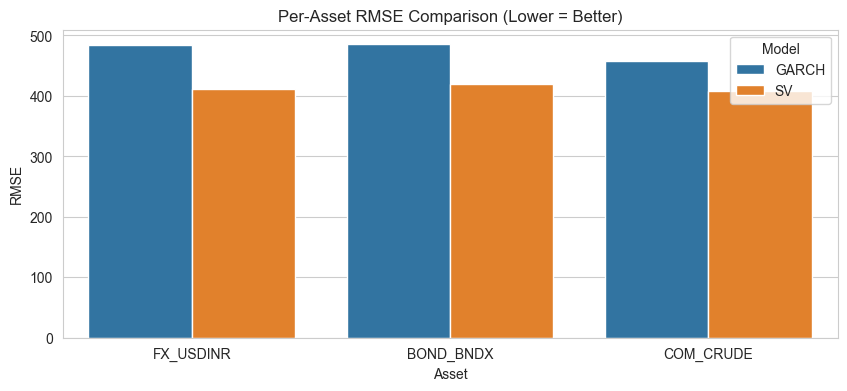

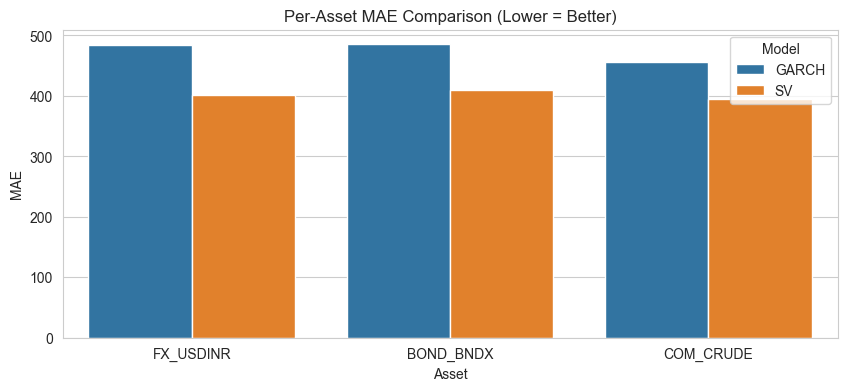

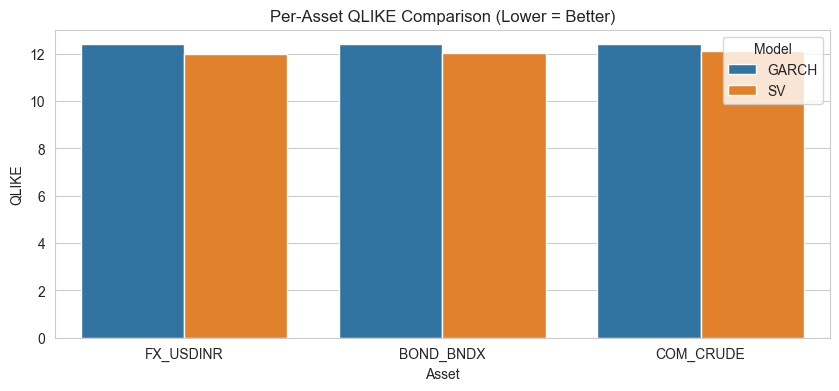

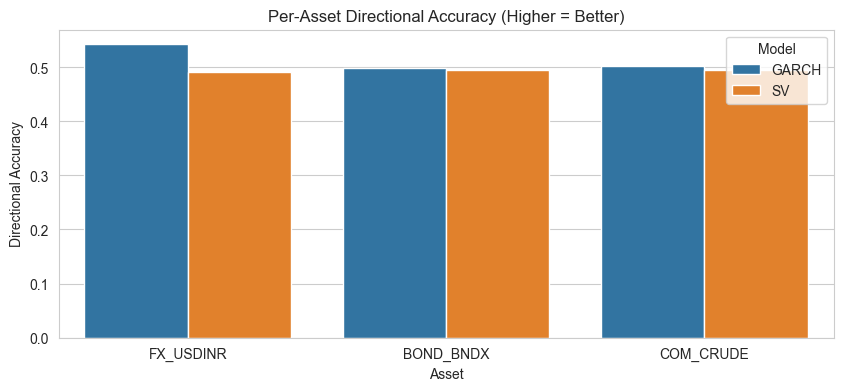

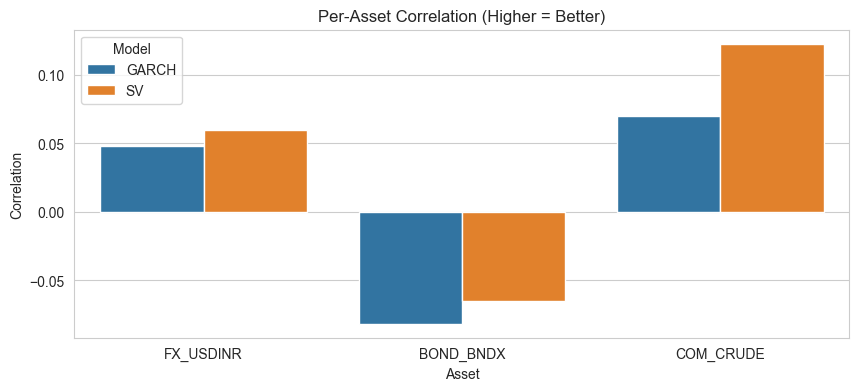

In [21]:
# -----------------------
# Per-asset bar plots (NEW)
# Mirror of per-shock bar plots but for assets
# -----------------------
if not metrics_df.empty:
    for metric in ["RMSE", "MAE", "QLIKE"]:
        fig = plt.figure(figsize=(10,4))
        sns.barplot(data=metrics_df, x="Asset", y=metric, hue="Model", errorbar=None,
                    palette=["tab:blue", "tab:orange"])
        plt.title(f"Per-Asset {metric} Comparison (Lower = Better)")
        plt.ylabel(metric)
        plt.xlabel("Asset")
        _save_and_show_plot(fig, "aggregate", f"per_asset_{metric.lower()}")

    # Also include Directional Accuracy per asset (higher = better)
    fig = plt.figure(figsize=(10,4))
    sns.barplot(data=metrics_df, x="Asset", y="Directional_Accuracy", hue="Model", errorbar=None,
                palette=["tab:blue", "tab:orange"])
    plt.title("Per-Asset Directional Accuracy (Higher = Better)")
    plt.ylabel("Directional Accuracy")
    plt.xlabel("Asset")
    _save_and_show_plot(fig, "aggregate", "per_asset_directional_accuracy")


    # Also include correlatoin per asset (higher = better)
    fig = plt.figure(figsize=(10,4))
    sns.barplot(data=metrics_df, x="Asset", y="Correlation", hue="Model", errorbar=None,
                palette=["tab:blue", "tab:orange"])
    plt.title("Per-Asset Correlation (Higher = Better)")
    plt.ylabel("Correlation")
    plt.xlabel("Asset")
    _save_and_show_plot(fig, "aggregate", "per_asset_correlation")
else:
    print("No asset data available for per-asset plotting.")

In [22]:
# %%
# --------------------------------------------
# Shock-specific metrics (compute shock_df)
# --------------------------------------------
shock_records = []
for shock, (s_start, s_end) in SHOCK_PERIODS.items():
    s_start, s_end = pd.to_datetime(s_start), pd.to_datetime(s_end)
    for asset in ASSETS:
        path = f"{RESULTS_PATH}/{asset}_merged_test.csv"
        if not os.path.exists(path):
            continue
        df = pd.read_csv(path, parse_dates=["date"])
        # filter to shock window
        df_s = df[(df["date"] >= s_start) & (df["date"] <= s_end)].copy()
        if df_s.empty or "realized_vol" not in df_s.columns:
            continue
        for col, model in [("garch_vol", "GARCH"), ("sv_vol", "SV")]:
            if col not in df_s.columns:
                continue
            preds = df_s[col].values * PRED_SCALE
            m = compute_metrics(df_s["realized_vol"].values, preds)
            m.update({"Asset": asset, "Model": model, "Shock": shock})
            shock_records.append(m)

shock_df = pd.DataFrame(shock_records)
print("Shock-specific metric table (shock_df) head:")
display(shock_df.head())


Shock-specific metric table (shock_df) head:


,RMSE,MAE,Correlation,Directional_Accuracy,QLIKE,Asset,Model,Shock
0,476.980192,476.940786,0.446306,0.500000,12.382001,FX_USDINR,GARCH,covid_shock
1,364.997174,364.647504,-0.195310,0.489583,11.858447,FX_USDINR,SV,covid_shock
2,483.516362,483.499561,0.483465,0.505376,12.381248,BOND_BNDX,GARCH,covid_shock
3,402.307293,400.654477,-0.582364,0.451613,12.002301,BOND_BNDX,SV,covid_shock
4,410.138121,406.390634,0.746436,0.537634,12.443055,COM_CRUDE,GARCH,covid_shock


=== Average Performance per Shock × Model ===


,Shock,Model,RMSE,MAE,QLIKE,Directional_Accuracy,Correlation
0,covid_shock,GARCH,456.878225,455.610327,12.402101,0.514337,0.558736
1,covid_shock,SV,384.451769,381.964282,12.063008,0.471438,-0.169859
2,inflation_energy_shock,GARCH,468.400854,468.252031,12.378822,0.518159,0.711518
3,inflation_energy_shock,SV,399.334034,397.796263,12.059774,0.528888,0.047062
4,oil_spike_shock,GARCH,476.221418,476.176236,12.375731,0.502135,0.731933
5,oil_spike_shock,SV,369.252465,367.736968,11.864090,0.491530,0.214570


=== Overall Average Performance Across Shocks (per Model) ===


,RMSE,MAE,QLIKE,Directional_Accuracy,Correlation
Model,,,,,
GARCH,467.166832,466.679531,12.385552,0.511543,0.667395
SV,384.346089,382.499171,11.995624,0.497286,0.030591


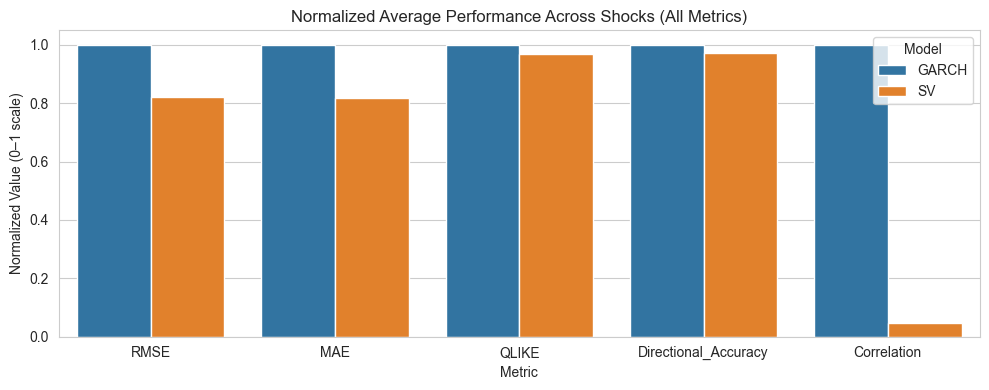

In [23]:
# %%
# --------------------------------------------
# Aggregate: Average performance across shocks (raw numbers)
# --------------------------------------------


if not shock_df.empty:

    # ---- (A) Average metrics per Shock × Model ----
    shock_avg = (
        shock_df
        .groupby(["Shock", "Model"])[["RMSE", "MAE", "QLIKE", "Directional_Accuracy", "Correlation"]]
        .mean()
        .reset_index()
    )
    print("=== Average Performance per Shock × Model ===")
    display(shock_avg)

    # ---- (B) Average across all shocks (overall per Model) ----
    avg_metrics = (
        shock_avg
        .groupby("Model")[["RMSE", "MAE", "QLIKE", "Directional_Accuracy", "Correlation"]]
        .mean()
    )
    print("=== Overall Average Performance Across Shocks (per Model) ===")
    display(avg_metrics)

    # ---- (C) Normalize for visualization (no inversion, consistent with asset-level) ----
    normed = avg_metrics.copy()
    normed = normed / normed.max()  # scale each metric 0–1 for comparison

    # ---- (D) Melt and plot ----
    melted = normed.reset_index().melt(
        id_vars="Model",
        value_vars=["RMSE", "MAE", "QLIKE", "Directional_Accuracy", "Correlation"],
        var_name="Metric",
        value_name="Normalized_Value"
    )

    fig = plt.figure(figsize=(10, 4))
    sns.barplot(data=melted, x="Metric", y="Normalized_Value", hue="Model", errorbar=None)
    plt.title("Normalized Average Performance Across Shocks (All Metrics)")
    plt.ylabel("Normalized Value (0–1 scale)")
    plt.xlabel("Metric")
    plt.tight_layout()

    # Save & show
    _save_and_show_plot(fig, "aggregate", "avg_error_metrics_across_shocks")

else:
    print("No shock data available for average-shock plotting.")



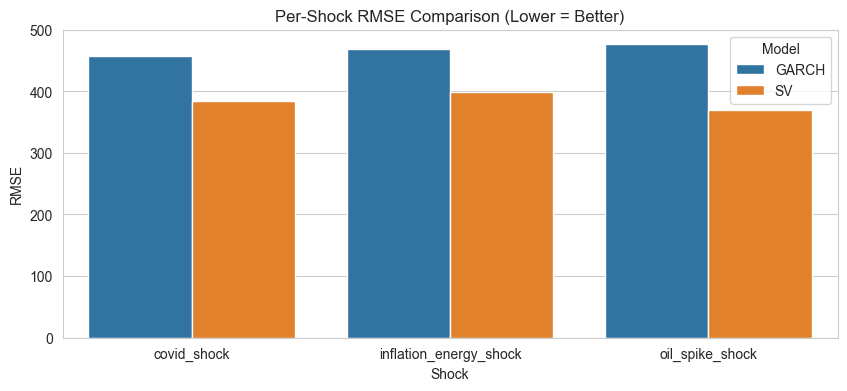

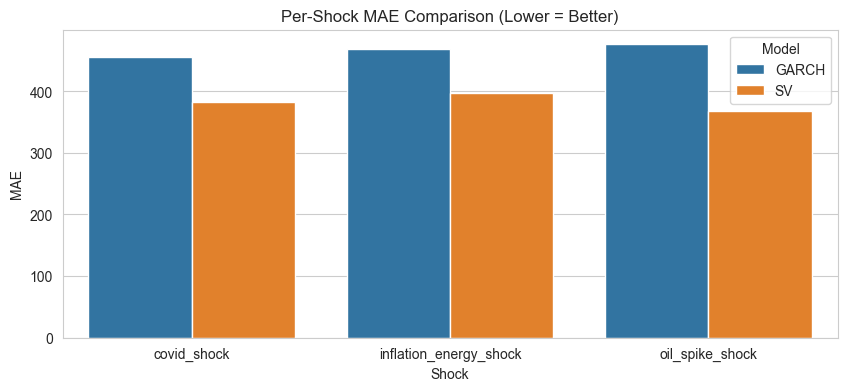

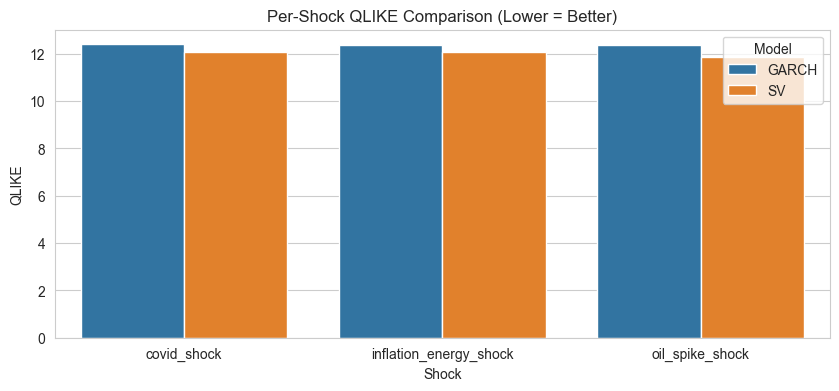

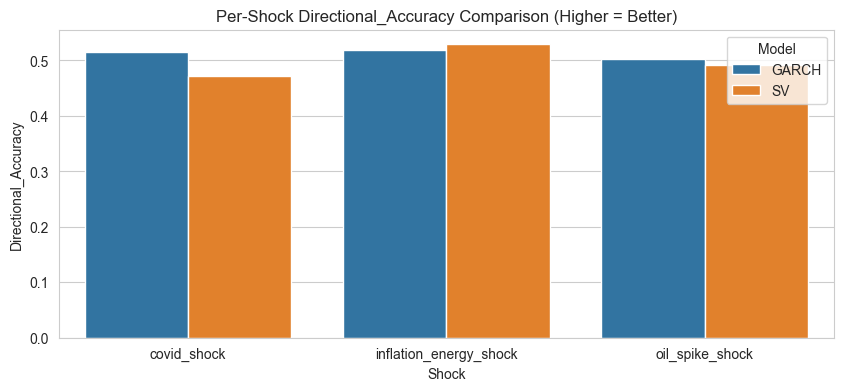

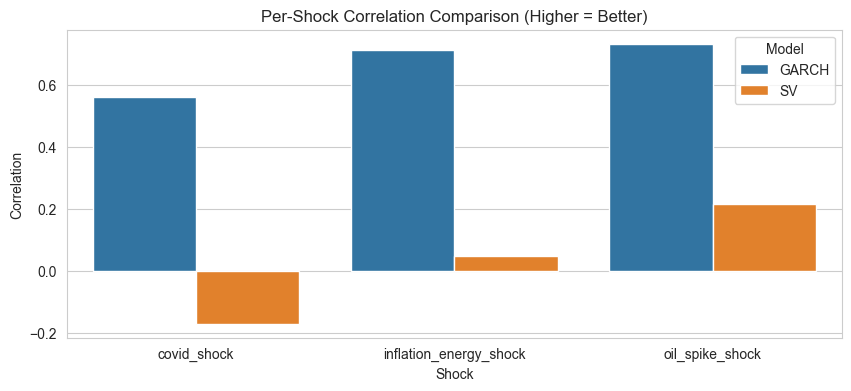

In [24]:
# %%
# --------------------------------------------
# Per-shock comparison (bar plots) — RMSE, MAE, QLIKE, directional accuracy
# --------------------------------------------

if not shock_df.empty:
    for metric, better in zip(
        ["RMSE", "MAE", "QLIKE", "Directional_Accuracy","Correlation"],
        ["Lower = Better", "Lower = Better", "Lower = Better", "Higher = Better","Higher = Better"]
    ):
        fig = plt.figure(figsize=(10, 4))
        sns.barplot(
            data=shock_df,
            x="Shock",
            y=metric,
            hue="Model",
            errorbar=None,
            palette=["tab:blue", "tab:orange"]
        )
        plt.title(f"Per-Shock {metric} Comparison ({better})")
        plt.ylabel(metric)
        plt.xlabel("Shock")
        _save_and_show_plot(fig, "aggregate", f"per_shock_{metric.lower()}")
else:
    print("No shock data available for plotting.")


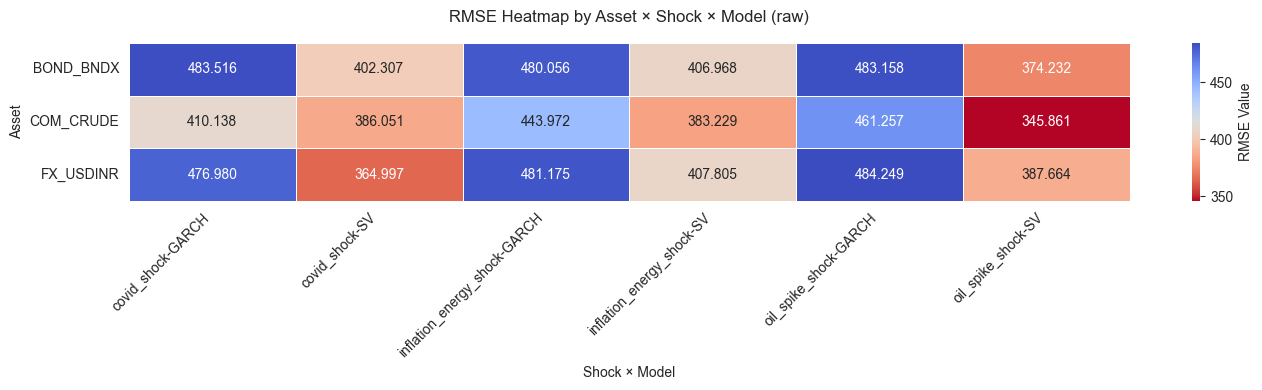

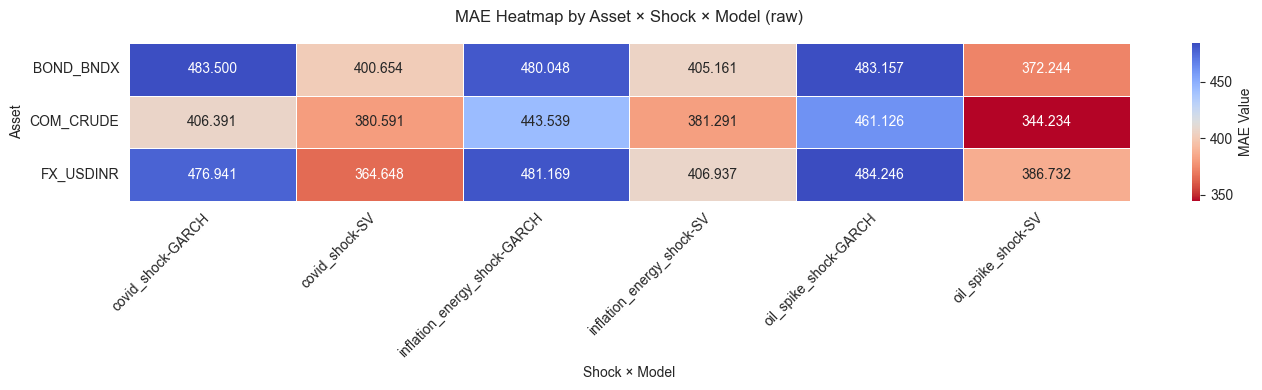

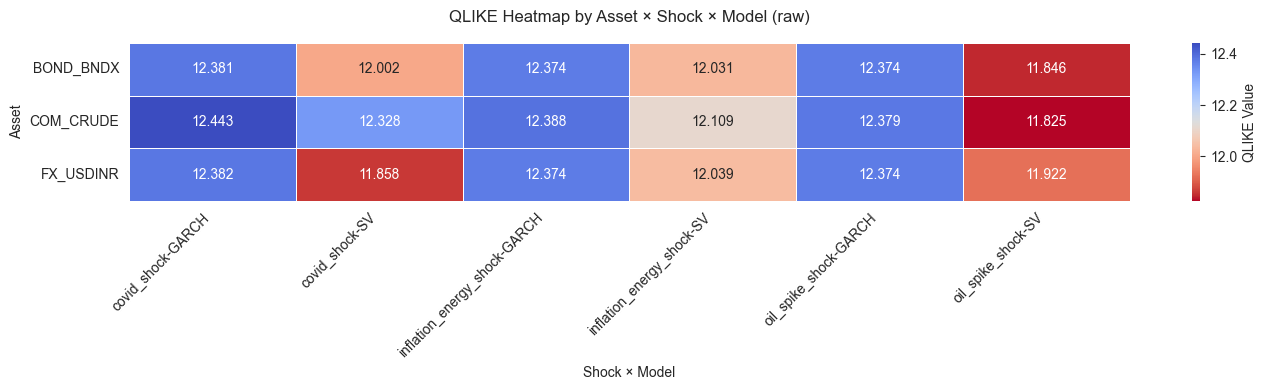

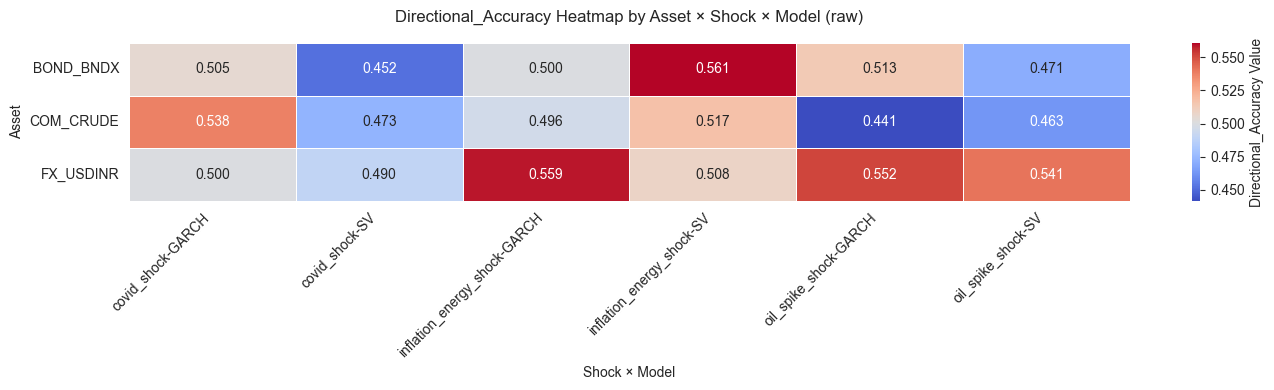

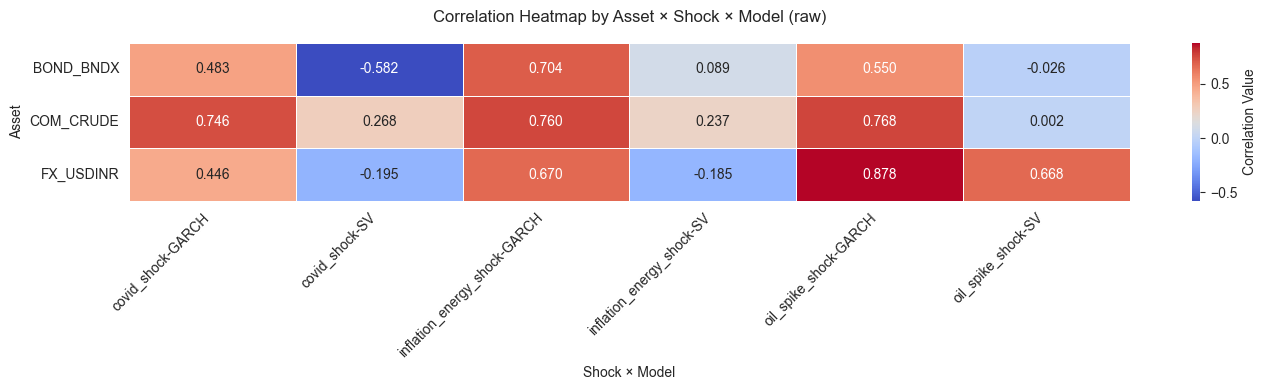

In [25]:
# %%
# --------------------------------------------
# Per-metric heatmaps: Asset × Shock × Model (raw values)
# --------------------------------------------
if not shock_df.empty:
    for metric in ["RMSE", "MAE", "QLIKE", "Directional_Accuracy", "Correlation"]:
        pivot = shock_df.pivot_table(values=metric, index="Asset", columns=["Shock", "Model"])

        # Choose color direction: higher = bad (for errors), higher = good (for performance)
        if metric in ["Directional_Accuracy", "Correlation"]:
            cmap = "coolwarm"       # high = good
        else:
            cmap = "coolwarm_r"     # high = bad

        # Create larger figure to prevent label overlap
        fig, ax = plt.subplots(figsize=(14, max(4, 0.6 * len(pivot))))  # dynamic height
        sns.heatmap(
            pivot,
            annot=True,
            fmt=".3f",
            cmap=cmap,
            linewidths=0.5,
            ax=ax,
            cbar_kws={"label": f"{metric} Value"}
        )

        # Improve layout and readability
        ax.set_title(f"{metric} Heatmap by Asset × Shock × Model (raw)", fontsize=12, pad=15)
        ax.set_xlabel("Shock × Model", fontsize=10)
        ax.set_ylabel("Asset", fontsize=10)
        plt.xticks(rotation=45, ha="right")
        plt.yticks(rotation=0)
        plt.tight_layout()

        # Save & show
        _save_and_show_plot(fig, "aggregate", f"heatmap_asset_shock_{metric.lower()}")

